Hashtags: #climatechange #chargingStations #electricalcars #

# Geographical analysis of charging stations for electrical cars in germany via OpenStreetMap Data and Python

Everyone is talking about electro mobility - this caught my interest and I wanted to know more about the charging station infrastructure in Germany.

To clarify this, I need to have data to analyze. One of the easiest ways to get data is to get a grip on open data provided by Open Street Map (OSM) under the open use license, see http://wwwwopenstreetmap.org.

On the way, there are exiting ways to tackle data problems analytically as well as fast geographic visualization tecniques. I am going to explain the used packages and provide links to suitable documentations. In between the written words there will be python code elements to support the analysis. So let's get into it.

## Receiving and evaluating data from OSM

Firstly, there exist several ways to extract data from OSM. If you want to find out more about it, see https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0 as a guiding reference. Let's dig a little deeper into OSM to find out how to get suitable data. The OSM data model is structured into nodes as a basic zero-dimensional object. On behalf of nodes, ways consist of nodes and relations between these objects. The descriptions of these objects are given by tag value pairs, see https://wiki.openstreetmap.org/ for further information about all of these. Searching for "charging_station" in Germany in all three data structures node, way and also relation regarding the amenity tag. (remark: data as of extraction October 2022)

In [ ]:
import requests

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="charging_station"](area);
 way["amenity"="charging_station"](area);
 rel["amenity"="charging_station"](area);
);
out center;
"""
response = requests.get(overpass_url, params={"data": overpass_query})
data = response.json()

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
# read old parquet table
df_stations_de = pq.read_table("20221006_stations.parquet").to_pandas()

The data-object which was returned consists of meta data and a key called 'elements' where the desired data was stored. For initial exploratoy data analysis pythons panda package is my prefered tool when it comes to tabular data. Therefore I use a json normalizer to shrink dimensionality a put the data into a pandas data frame.

In [ ]:
import pandas as pd
from pandas import json_normalize

df_stations_de = json_normalize(data["elements"])

df_stations_de.shape

In october 2022 there appear about 19.5K rows and 682 columns. That means about 19.5K charging stations are listed in this data set - powered by this awesome community this is increasing every day. In contrast the amount of columns is also increasing since there is a freedom in creating new features andthe way of filling data in is somehow not very clear in a way. Therefore about 98% of all cells are just empty - missing values.

For this purpose the columns id, lat, lon and the operator are apparently most interesting storing the individual geographical position of the charging station in germany and the operator.

## A comment on official sources and historisation

OSM is maintained and updated by an open data community of volunteers who document infrastructure. The pace on how this infrastructure of charging stations changes is currently at speed. Taking a closer look at official pages of the Bundesnetzagentur (BNetzA), see https://www.bundesnetzagentur.de/DE/Fachthemen/ElektrizitaetundGas/E-Mobilitaet/Ladesaeulenkarte/start.html, where official data is being distributed, you will find about 24K unique adresses of charging stations in germany in October 2022. This gap could be due to volunteering documentation versus official documentation, but it should not effect the methods and analysis at this point.

Wondering how fast the documentation went in the past years, one could find a historization of tags on https://taginfo.openstreetmap.org or see http://taghistory.raifer.tech. Whenever we want to store and historize the received data for ourselves there are ways to cache data via, e.g. parquet files.

## Find hot spots and lonesome charging stations

So for now there is just downloaded data and a comment on data quality and historization. The interesting columns for a geographical analysis are latitude and longitude, named lat and lon here. These columns are measured in degree in a specific coordinate reference system, crs. In the world of Geographical Information Systems (GIS) there exist a lot of crs actually, usually with different approaches and determinations going back to the Hellenic Period, see https://en.wikipedia.org/wiki/Spatial_reference_system. If you want to find more about it, see for example https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/. A crs measured in degree is handy for a spherical interpretation around the entire globe, called geographical coordinate system. Here, you cannot measure differences of two points easily to find the distance in meters. Therefore a local projection coordinate system is necessary that translates a spherical projection to a local one. This can be done by the Transformer package in Python. Here, directly creating two new columns measuring in a sufficient projected coordinate system.

In [ ]:
from pyproj import Transformer

df_short = df_stations_de[["id", "lat", "lon", "tags.operator"]]

transformer = Transformer.from_crs(4326, 25832)

lat_X, lon_Y = transformer.transform(df_short.lat, df_short.lon)

df_short.insert(4, "X", list(lat_X))
df_short.insert(5, "Y", list(lon_Y))

After mastering this hurdle, one could use DBSCAN algorithm to tackle to questions:
1. Are there stations where there is no other station in the range of 10 kilometers?
2. Where is the highest density of charging stations?

The DBSCAN algorithm handles both pretty good. It works as follows: It has to different parameters, eps and min_samples. Taking a starting point x_0 it measure a circle of radius eps and takes a look if there is another point in this circle of the corresponding data set. If this is not the case, then it will get the cluster flag -1 and will be treated as noise, the N in DBSCAN. If there is another point in the circle, then this point will be used to draw another circle which is the starting point for iteration through the whole dataset. All points are defined as a cluster when the amount of min_samples is at minimum reached. Then it gets is own cluster number, otherwise it will be treated as noise again.

Therefore DBSCAN acts like a clustering algorithm without at forehand saying how many clusters to expect or indicating a certain form of the cluster. Choosing eps too large, the whole dataset is just one cluster. Choosing eps too small will result in singular points and just noise.

Here, a transformation of two columns into a numpy array is a starting to point to fit DBSCAN afterwards. Two different parameter settings, one to find lonesome stations and one to find dense stations of minimum 5 stations with intermediate distance 200m are implemented below, see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html for details.

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

X = df_short[["X", "Y"]].to_numpy()

clustering = DBSCAN(eps=10000, min_samples=2).fit(X)
df_short.insert(6, "cluster_10K", list(clustering.labels_))

clustering = DBSCAN(eps=200, min_samples=5).fit(X)
df_short.insert(7, "cluster_200m", list(clustering.labels_))

By typing in `df_short.cluster_10K.value_counts()` there pops up a brief tabular overview on how many clusters have been created. Instead, I want to visualize this on a folium map, see https://python-visualization.github.io/folium/ for details.

After importing folium package there is a map object `m` which will be centered at median values of latitude and longitude. A suitable start for a zoom-factor here might be 5 to get an overview of german charging stations. The `tiles` attribute adjustes which backround map is displayed where my personally preferred tile is `cartodbpositron`. It focusses on graphical understatement pushing markers and polygons to the front due to readability. Here, I have tried something new using `cartodbdark_matter` - let us see what happens.

In [ ]:
import folium as fl

m = fl.Map(
    location=[df_stations_de.lat.median(), df_stations_de.lon.median()],
    zoom_start=5,
    tiles = 'cartodbdark_matter'
    #tiles='cartodbpositron',
)
m

The outcomes from DBSCAN above can now be added to the map. Therefore so called feature groups or layers are created and named adequately. For the sake of simplicity we cycle through data now - two times - there is definetely space for optimization. By filtering on the noise points indicated by `-1` charging stations without any other stations in a 10 kilometers radius will be added. In the latter charging stations for dense clusters are added. Again, by typing in `m` this map will be displayed and one can dynamically discover charging stations also locally. As a remark, by `m.save('my_file.html')` this can be exported as html-file.

In [ ]:
layer_cluster_alone = fl.FeatureGroup(name="stations - alone in 10km",
                                      show=True)
for i in range(0, df_short.shape[0]):
    if df_short.cluster_10K.iloc[i] == -1:
        fl.Circle(
            location=[df_short.iloc[i].lat, df_short.iloc[i].lon],
            radius=10,
            color="dodgerblue",
            opacity=0.8,
        ).add_to(layer_cluster_alone)
m.add_child(layer_cluster_alone)

layer_cluster_dense = fl.FeatureGroup(name="stations - 200m - dense minimum 5",
                                      show=True)
for i in range(0, df_short.shape[0]):
    if df_short.cluster_200m.iloc[i] != -1:
        fl.Circle(
            location=[df_short.iloc[i].lat, df_short.iloc[i].lon],
            radius=10,
            color="limegreen",
            opacity=0.8,
        ).add_to(layer_cluster_dense)
m.add_child(layer_cluster_dense)

fl.LayerControl().add_to(m)

m

### Wrap Up - First analysis

From a plain data viewpoint this DBSCAN-algorithm splitted the dataset in three categories where now two are visible in a geographical context right now - the dense stations, the lonesome stations and the rest - mutually exclusive. Embedding this analysis in a context of density where people live in germany, then this map is no surprise at all. One could go further here and add zip codes geometries and experiment with population density as well. From a GIS-technique viewpoint this would lead to more complex routines where packages like `geopandas` or `rtree` come into play. For now I leave it as is and focus on operators and local clusters.


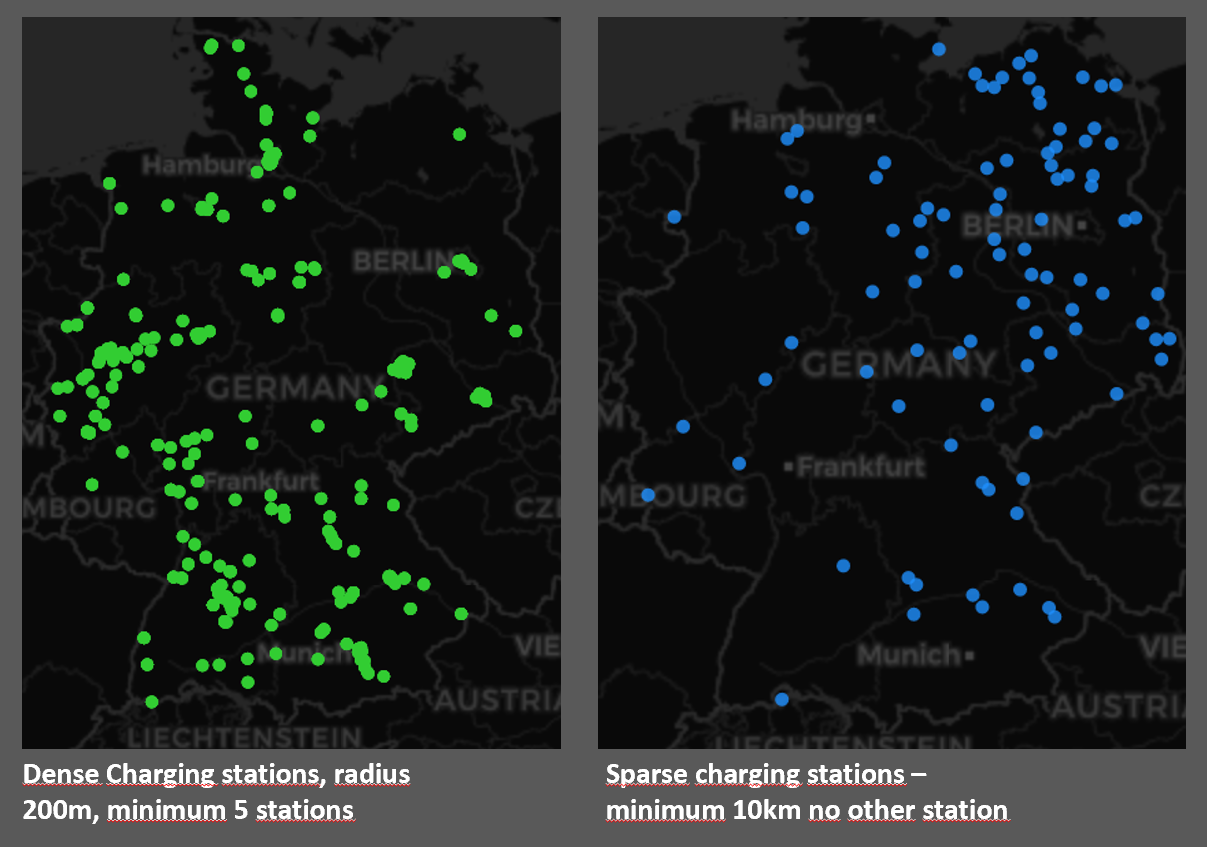


## Operator operations

Taking a closer look at column `tags.operator` shows that some are not homogeneously written. Therefore a brief cleansing is performed in the next code part. This should be adopted whenever there is new data since other anomalies could appear.

In [ ]:
df_short.insert(8, "operator_clean", df_short["tags.operator"].str.lower().to_list())

replace_list = [" gmbh", " energie baden-württemberg ag", " ag", ".", "-effizienz", ", inc"]
for i in replace_list:
    df_short["operator_clean"] = df_short["operator_clean"].str.replace(i,"")

In fact, this implementation shrinks the different expressions from about 3,682 different operators to 3,283 operators, still having 4,819 missing values, which is more than 24%. To append a suitable color mapping for every operator, I am aggregating over `operator_clean` and choose different colors for the first 50 biggest operators and the rest. A reintegration into `df_short` takes us to the creation of a map in the next step.

In [ ]:
# aggregation over clean operators to attach suitable colors
df_agg_op = df_short["operator_clean"].value_counts().reset_index()
df_agg_op.rename(columns = {'index':'operator_clean',
                            'operator_clean':'amount'},
                 inplace = True)

color_list_1 = ["limegreen"]*(df_agg_op[df_agg_op.amount >= 50].shape[0])

df_agg_op['color_operator'] = color_list_1 + ['lightgray']*(df_agg_op.shape[0]-df_agg_op[df_agg_op.amount >= 50].shape[0])

df_short = df_short.merge(df_agg_op[['operator_clean', 'color_operator']],
                         on = 'operator_clean',
                         how = 'left')

df_short["color_operator"] = df_short["color_operator"].fillna("darkgray")

list_operator = df_agg_op[df_agg_op.amount >= 50].operator_clean.to_list()

Basically, there will be two different operations in the next code block. First, creating a layer for every operator from the above list and then the rest of them. In every loop tons of folium circle objects are created and added to the map with corresponding coordinates and colors. When clicking on the different operators you will find that they are either very local players or equally distributed over whole germany.

In [ ]:
m2 = fl.Map(
    location=[df_stations_de.lat.median(), df_stations_de.lon.median()],
    zoom_start=5,
    tiles = 'cartodbdark_matter'
)

for i in list_operator:
    layer = fl.FeatureGroup(name = i, show = False)
    df_in = df_short[df_short.operator_clean == i].reset_index(drop = True)
    for index, row in df_in.iterrows():
        fl.Circle(location=(row["lat"], row["lon"]),
                radius = 1,
                color = row["color_operator"],
                popup = row["operator_clean"],
                fill = False).add_to(layer)
    m.add_child(layer)

layer_noperator = fl.FeatureGroup(name="No operator map", show=False)
for index, row in df_short.iterrows():
    if ((row["color_operator"] == "darkgray") or (row["color_operator"] == "lightgray")):
        fl.Circle(location=(row["lat"], row["lon"]),
                        radius = 1,
                        color = row["color_operator"],
                        popup = row["operator_clean"],
                        fill = False).add_to(layer_noperator)

m2.add_child(layer_noperator)

fl.LayerControl().add_to(m2)

m2

Going deeper into regional operators we create a mapping to figure out which operators are regional and which are not. For the sake of simplicity this has been hard encoded via a dictionary.

In [ ]:
dict_operator_regional = {'enbw': 0,
 'stromnetz hamburg': 1,
 'innogy': 0,
 'stadtwerke münchen': 1,
 'ewe go': 0,
 'allego': 0,
 'ionity': 0,
 'rwe': 0,
 'sachsenenergie': 1,
 'lidl': 0,
 'eon': 0,
 'tesla': 0,
 'aldi süd': 0,
 'rewag': 1,
 'rheinenergie': 1,
 'e-wald': 0,
 'energie baden-württemberg': 0,
 'n-ergie': 0,
 'enercity': 1,
 'ikea': 0,
 'lechwerke': 1,
 'kaufland': 0,
 'e-regio & co kg': 1,
 'stadtwerke stuttgart': 1,
 'swu stadtwerke ulm/neu-ulm': 1,
 'pfalzwerke': 0,
 'be emobil': 1,
 'new': 1,
 'eins energie in sachsen': 1,
 'stadtwerke bielefeld': 1,
 'swb': 0,
 'aral': 0}

By importing the `Polygon` function from `shapely` package there is a chance to symbolize the `convex_hull`, i.e. an outer point polygon of a set of points, in this map. To do this adequately the actual choice of points due to the operator has been mapped to a list and will be pairwise zipped to apply the `Polygon` function. The `convex_hull` attribut then creates a Polygon object that can be shown in the corresponding layer called `fg_reg`. For the non-regional operators we simply plot all corresponding charging stations.

In [ ]:
from shapely.geometry import Polygon

m3 = fl.Map(
    location=[df_stations_de.lat.median(), df_stations_de.lon.median()],
    zoom_start=5,
    tiles="cartodbdark_matter",
)

fg_reg = fl.FeatureGroup(name = "regional")
#fg_ntwd = fl.FeatureGroup(name = "nationwide")

# iterate through
for i in list_operator:
    if dict_operator_regional[i] == 1:
        
        obj_geojson = fl.GeoJson(Polygon(zip(df_short[df_short.operator_clean == i].lon.to_list(),
                               df_short[df_short.operator_clean == i].lat.to_list())).convex_hull,
            style_function=lambda feature, col='limegreen': {
                "fillColor": 'limegreen',
                "lineColor": 'limegreen',
                "color": 'limegreen',
                "opacity" : 0.8
            },
                  )
        fl.Popup(i).add_to(obj_geojson)
        obj_geojson.add_to(fg_reg)
    elif dict_operator_regional[i] == 0:
        fg = fl.FeatureGroup(name = i, show = False)
        df_in = df_short[df_short.operator_clean == i].reset_index(drop = True)
        for index, row in df_in.iterrows():
            fl.Circle(location=(row["lat"], row["lon"]),
                    radius = 1,
                    color = row["color_operator"],
                    popup = row["operator_clean"],
                    fill = False).add_to(fg)
        fg.add_to(m3)
# fg_ntwd.add_to(map1)
fg_reg.add_to(m3)

fl.LayerControl().add_to(m3)

m3

This gives a glance at why geographical maps are very rarely used in business intelligence visualizations - it can come along pretty confusing and not too informative. But here is a little wrap up of what has been found in this analysis:

## Wrap Up

Charging stations are not equally distributed over germany. In metropolitan areas there is a higher availability than in rural areas. This is somehow a validation of what one might think when considering data of charging stations. When looking carefully at operator data and clustering there exist regional operators and non-regional operators. Regional operators are usually municipal suppliers who are driving the electromobility change on a local basis. 

Then, there are retailers who use their location infrastructure to attract drivers of e-vehicles like Aldi, Lidl, Ikea or Kaufland, all very much equally distributed. Different to that are energy operators like Innogy, EnBW or RWE to name just a few have their core area from where they seem to have spread all over germany. In contrast to these, there seem to be Tesla or eon with equal distribution as a strategy. 